In [223]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

def parse_log_line(line):
    """
    Parse a single log line using regex with precise timestamp
    """
    pattern = r'^(\S+) \S+ \S+ \[([^\]]+)\] "([^"]*)" (\d+) (\d+) "([^"]*)" "([^"]*)"'
    match = re.match(pattern, line.strip())
    
    if match:
        ip, timestamp, request, status_code, size, referrer, user_agent = match.groups()
        
        try:
            # Mantendo a precisão dos segundos no parsing
            parsed_time = datetime.strptime(timestamp, '%d/%b/%Y:%H:%M:%S %z')
        except ValueError:
            print(f"Failed to parse timestamp: {timestamp}")
            return None
        
        try:
            method, path, protocol = request.split(' ')
        except ValueError:
            method, path, protocol = 'Unknown', 'Unknown', 'Unknown'
        
        return {
            'ip': ip,
            'timestamp': parsed_time,
            'method': method,
            'path': path,
            'protocol': protocol,
            'status_code': int(status_code),
            'size': int(size),
            'referrer': referrer,
            'user_agent': user_agent
        }
    return None

def parse_log_file(filename):
    """
    Parse log file and return DataFrame
    """
    parsed_logs = []
    with open(filename, 'r', encoding='utf-8') as file:
        for line in file:
            parsed_line = parse_log_line(line.strip())
            if parsed_line:
                parsed_logs.append(parsed_line)
    
    return pd.DataFrame(parsed_logs)

# Carregar e processar o arquivo de log
df = parse_log_file('access_23012019.log')



In [164]:
display(df)

,ip,timestamp,method,path,protocol,status_code,size,referrer,user_agent
0,77.77.74.169,2019-01-23 00:00:00+03:30,GET,/image/904/brand,HTTP/1.1,200,7339,https://www.zanbil.ir/browse/digital-supplies/...,Mozilla/5.0 (Windows NT 6.3; Win64; x64; rv:64...
1,77.77.74.169,2019-01-23 00:00:00+03:30,GET,/image/8/brand,HTTP/1.1,200,2427,https://www.zanbil.ir/browse/digital-supplies/...,Mozilla/5.0 (Windows NT 6.3; Win64; x64; rv:64...
2,77.77.74.169,2019-01-23 00:00:00+03:30,GET,/image/515/brand,HTTP/1.1,200,2226,https://www.zanbil.ir/browse/digital-supplies/...,Mozilla/5.0 (Windows NT 6.3; Win64; x64; rv:64...
3,77.77.74.169,2019-01-23 00:00:00+03:30,GET,/image/3/brand,HTTP/1.1,200,2885,https://www.zanbil.ir/browse/digital-supplies/...,Mozilla/5.0 (Windows NT 6.3; Win64; x64; rv:64...
4,77.77.74.169,2019-01-23 00:00:00+03:30,GET,/image/653/brand,HTTP/1.1,200,3190,https://www.zanbil.ir/browse/digital-supplies/...,Mozilla/5.0 (Windows NT 6.3; Win64; x64; rv:64...
...,...,...,...,...,...,...,...,...,...
2328559,46.224.114.216,2019-01-23 23:59:59+03:30,GET,/image/6213/productType/240x180,HTTP/1.1,200,17786,https://www.zanbil.ir/filter/b2,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
2328560,5.234.226.87,2019-01-23 23:59:59+03:30,GET,/image/26531?name=dc34-443.jpg&wh=max,HTTP/1.1,200,18377,https://www.zanbil.ir/m/product/26531/54272/%D...,Mozilla/5.0 (Linux; Android 8.1.0; SAMSUNG SM-...
2328561,46.224.114.216,2019-01-23 23:59:59+03:30,GET,/image/5935/productType/240x180,HTTP/1.1,200,17326,https://www.zanbil.ir/filter/b2,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
2328562,46.224.114.216,2019-01-23 23:59:59+03:30,GET,/image/1/brand,HTTP/1.1,200,3924,https://www.zanbil.ir/filter/b2,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...


In [180]:
# Padronizar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [185]:
OMP_NUM_THREADS=1

In [187]:
# Realizar K-Means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_scaled)

KMeans(n_clusters=5, random_state=42)

In [189]:
 # Adicionar coluna de cluster
df['cluster'] = kmeans.labels_

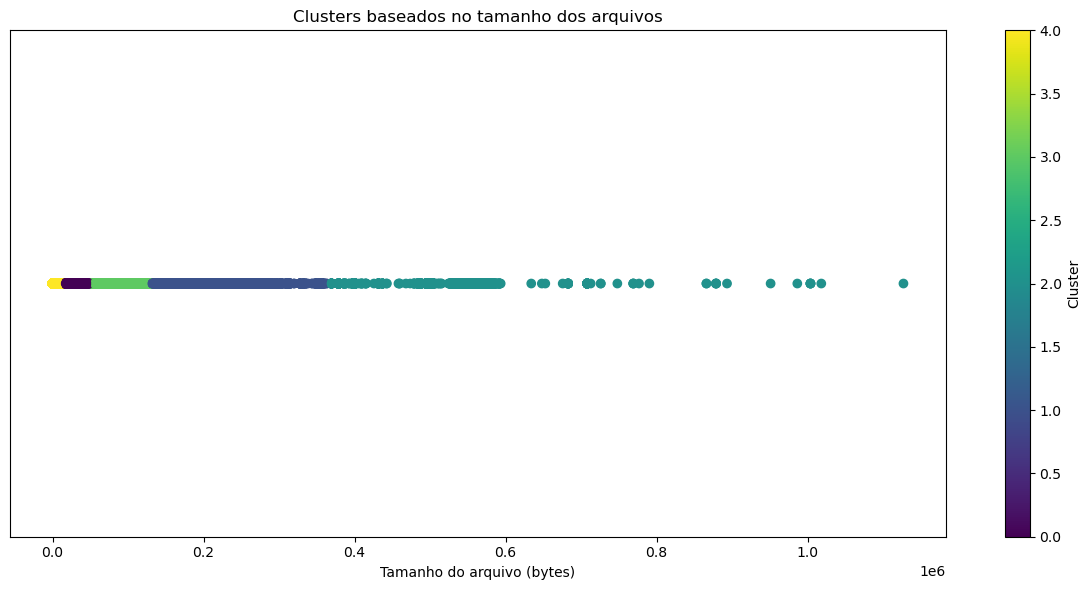

In [191]:
# Visualizar os clusters
plt.figure(figsize=(12, 6))
scatter = plt.scatter(X['size'], [0]*len(X), c=df['cluster'], cmap='viridis')
plt.title('Clusters baseados no tamanho dos arquivos')
plt.xlabel('Tamanho do arquivo (bytes)')
plt.yticks([])
plt.colorbar(scatter, label='Cluster')
plt.tight_layout()
plt.show()

In [193]:
# Resumo estatístico dos clusters
cluster_summary = df.groupby('cluster')['size'].agg([
    ('count', 'count'),
    ('mean', 'mean'),
    ('min', 'min'),
    ('max', 'max')
]).round(2)
print("\nResumo dos Clusters:")
print(cluster_summary)


Resumo dos Clusters:
           count       mean     min      max
cluster                                     
0         392177   27611.56   15525    50931
1          12803  189511.22  131980   367656
2           3546  547183.21  369482  1126965
3          99889   74305.78   50960   131905
4        1820149    3438.25       0    15524


<Figure size 1200x600 with 0 Axes>

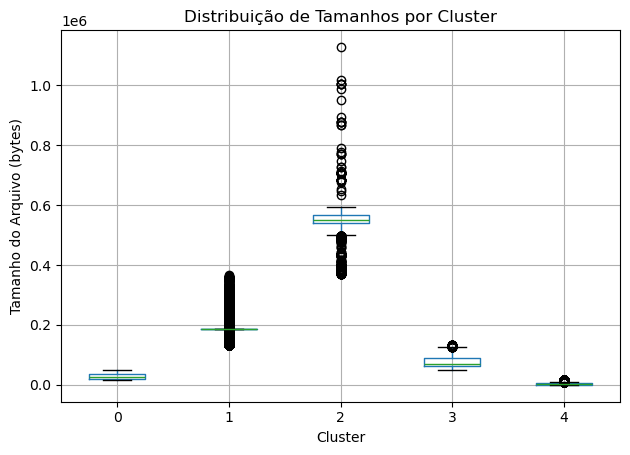

In [195]:
# Distribuição de tamanhos por cluster
plt.figure(figsize=(12, 6))
df.boxplot(column='size', by='cluster')
plt.title('Distribuição de Tamanhos por Cluster')
plt.suptitle('')  # Remove automatic suptitle
plt.xlabel('Cluster')
plt.ylabel('Tamanho do Arquivo (bytes)')
plt.tight_layout()
plt.show()

In [197]:
# Informações adicionais
print("\nInformações detalhadas do DataFrame:")
print(df.info())


Informações detalhadas do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2328564 entries, 0 to 2328563
Data columns (total 10 columns):
 #   Column       Dtype                    
---  ------       -----                    
 0   ip           object                   
 1   timestamp    datetime64[ns, UTC+03:30]
 2   method       object                   
 3   path         object                   
 4   protocol     object                   
 5   status_code  int64                    
 6   size         int64                    
 7   referrer     object                   
 8   user_agent   object                   
 9   cluster      int32                    
dtypes: datetime64[ns, UTC+03:30](1), int32(1), int64(2), object(6)
memory usage: 168.8+ MB
None


In [199]:
# Análise de Métodos HTTP
method_counts = df['method'].value_counts()
method_percentages = method_counts / len(df) * 100

print("Percentual de Métodos HTTP:")
for method, percentage in method_percentages.items():
    print(f"{method}: {percentage:.4f}%")

Percentual de Métodos HTTP:
GET: 98.0679%
POST: 1.5392%
HEAD: 0.3667%
OPTIONS: 0.0220%
Unknown: 0.0041%
CONNECT: 0.0001%


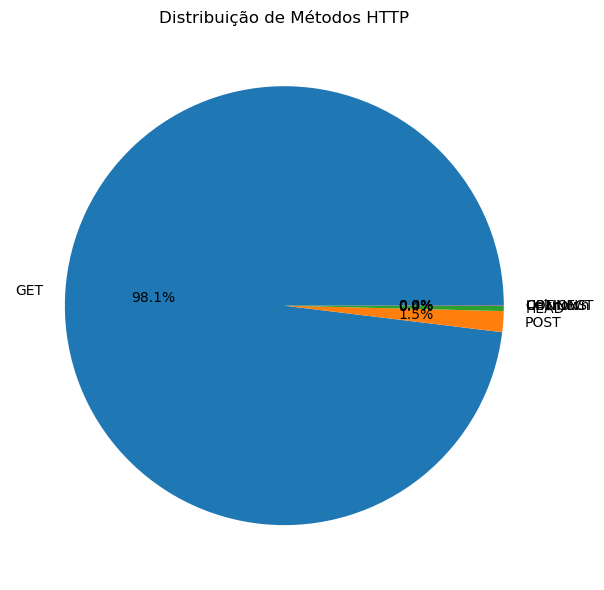

In [201]:
# Visualização de Métodos HTTP
plt.figure(figsize=(20, 6))
method_percentages.plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribuição de Métodos HTTP')
plt.ylabel('')
plt.tight_layout()
plt.show()

In [203]:
# Análise de Códigos de Status
status_counts = df['status_code'].value_counts()
status_percentages = status_counts / len(df) * 100

print("\nPercentual de Códigos de Status:")
for status, percentage in status_percentages.items():
    print(f"Status {status}: {percentage:.2f}%")


Percentual de Códigos de Status:
Status 200: 91.57%
Status 304: 3.83%
Status 302: 2.02%
Status 404: 1.02%
Status 301: 0.97%
Status 499: 0.51%
Status 403: 0.04%
Status 500: 0.02%
Status 502: 0.01%
Status 400: 0.00%
Status 401: 0.00%
Status 408: 0.00%
Status 414: 0.00%
Status 405: 0.00%
Status 206: 0.00%


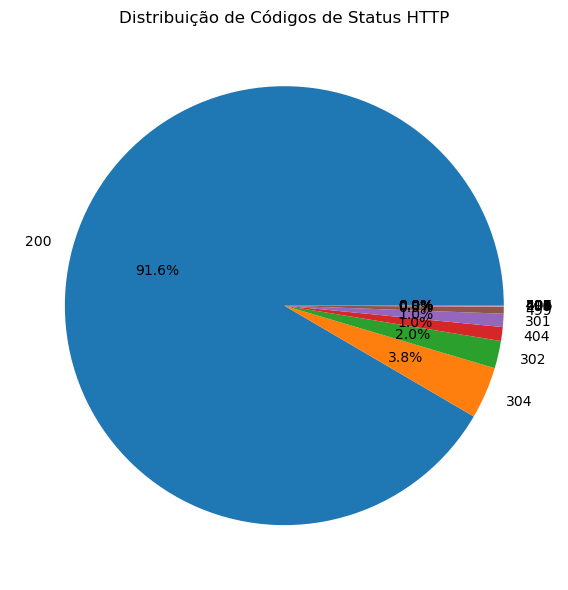

In [205]:
# Visualização de Códigos de Status
plt.figure(figsize=(10, 6))
status_percentages.plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribuição de Códigos de Status HTTP')
plt.ylabel('')
plt.tight_layout()
plt.show()

In [207]:
# Análise de Métodos por Status de Resposta
method_status_crosstab = pd.crosstab(df['method'], df['status_code'], normalize='index') * 100
print("\nPercentual de Status por Método:")
print(method_status_crosstab.round(2))


Percentual de Status por Método:
status_code     200  206    301   302   304     400  401   403    404  405  \
method                                                                       
CONNECT        0.00  0.0   0.00  0.00  0.00  100.00  0.0  0.00   0.00  0.0   
GET           91.79  0.0   0.93  1.98  3.91    0.00  0.0  0.04   0.82  0.0   
HEAD          23.06  0.0  17.80  0.04  0.00    0.01  0.0  0.00  58.61  0.0   
OPTIONS      100.00  0.0   0.00  0.00  0.00    0.00  0.0  0.00   0.00  0.0   
POST          94.02  0.0   0.00  5.35  0.00    0.00  0.0  0.02   0.01  0.0   
Unknown        0.00  0.0   0.00  0.00  0.00   88.54  0.0  0.00   0.00  0.0   

status_code  408    414   499   500   502  
method                                     
CONNECT      0.0   0.00  0.00  0.00  0.00  
GET          0.0   0.00  0.51  0.02  0.01  
HEAD         0.0   0.00  0.42  0.06  0.00  
OPTIONS      0.0   0.00  0.00  0.00  0.00  
POST         0.0   0.00  0.49  0.09  0.01  
Unknown      0.0  11.46  0.00  0.

<Figure size 1200x600 with 0 Axes>

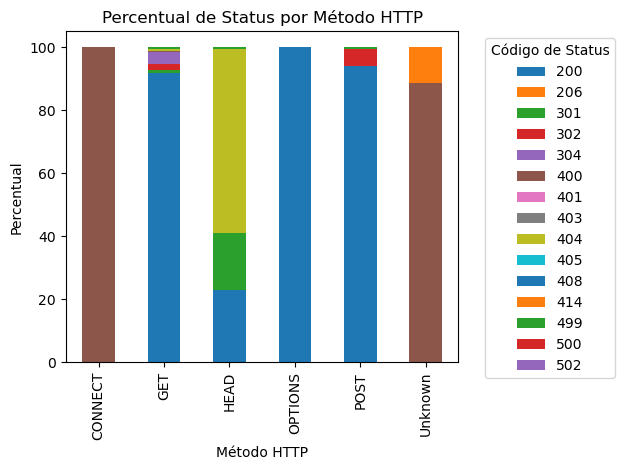

In [209]:
# Visualização de Métodos por Status
plt.figure(figsize=(12, 6))
method_status_crosstab.plot(kind='bar', stacked=True)
plt.title('Percentual de Status por Método HTTP')
plt.xlabel('Método HTTP')
plt.ylabel('Percentual')
plt.legend(title='Código de Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

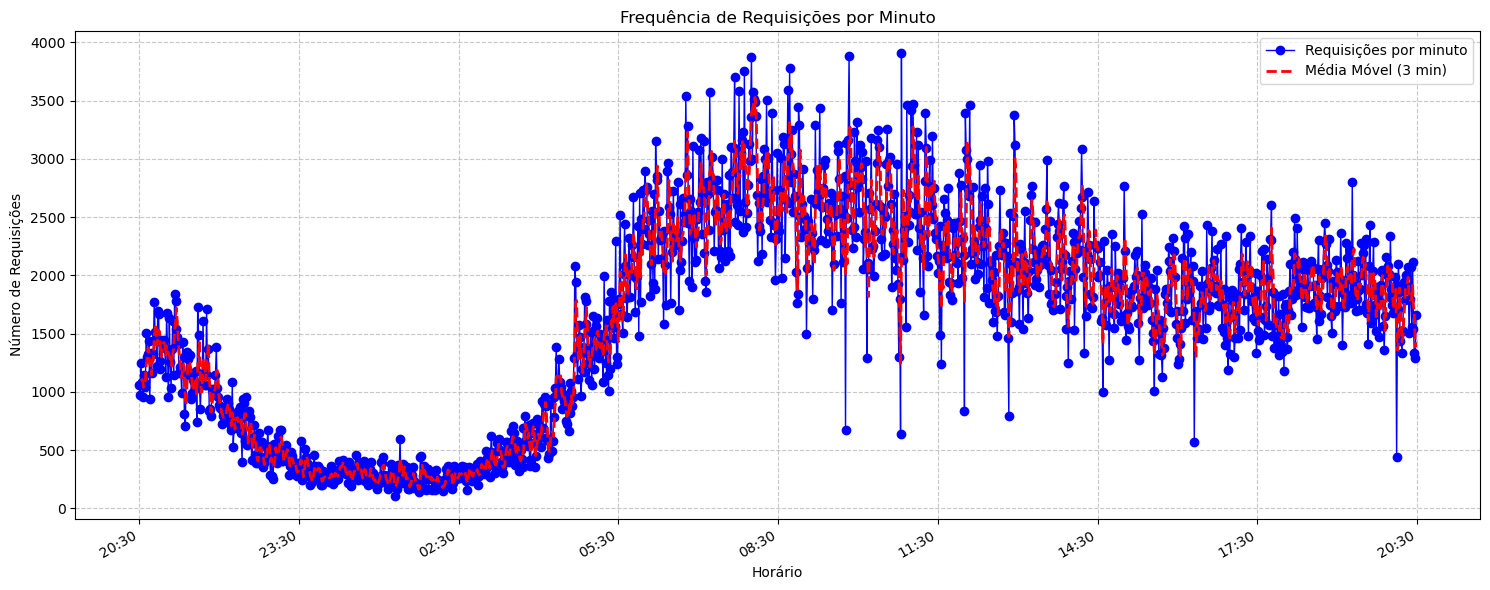


Estatísticas de Requisições por Minuto:
count    1440.000000
mean     1617.058333
std       891.338966
min       103.000000
25%       778.500000
50%      1758.500000
75%      2270.000000
max      3904.000000
Name: request_count, dtype: float64

Minutos com mais requisições:
Horário: 14:19 - Requisições: 3904
Horário: 13:20 - Requisições: 3882
Horário: 11:30 - Requisições: 3875
Horário: 12:13 - Requisições: 3781
Horário: 11:22 - Requisições: 3755


In [225]:
if not df.empty:
    # Criar coluna de minuto truncando os segundos
    df['minute'] = df['timestamp'].dt.floor('min')
    
    # Agrupar por minuto e contar requisições
    requests_per_minute = df.groupby('minute').size().reset_index(name='request_count')
    requests_per_minute = requests_per_minute.sort_values('minute')
    plt.figure(figsize=(15, 6))
    
    # Criar o gráfico com todos os pontos de dados
    plt.plot(requests_per_minute['minute'], 
            requests_per_minute['request_count'],
            'bo-',
            markersize=6,
            linewidth=1,
            label='Requisições por minuto')
    
    # Configurar o gráfico
    plt.title('Frequência de Requisições por Minuto')
    plt.xlabel('Horário')
    plt.ylabel('Número de Requisições')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Formatar eixo x para mostrar hora:minuto
    plt.gcf().autofmt_xdate()
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))
    
    # Adicionar média móvel de 3 minutos
    moving_avg = requests_per_minute['request_count'].rolling(window=3).mean()
    plt.plot(requests_per_minute['minute'], 
            moving_avg, 
            'r--', 
            linewidth=2,
            label='Média Móvel (3 min)')
    
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Estatísticas
    print("\nEstatísticas de Requisições por Minuto:")
    print(requests_per_minute['request_count'].describe())
    
    print("\nMinutos com mais requisições:")
    top_minutes = requests_per_minute.nlargest(5, 'request_count')
    for _, row in top_minutes.iterrows():
        print(f"Horário: {row['minute'].strftime('%H:%M')} - Requisições: {row['request_count']}")
    
    # Salvar resultados
    requests_per_minute.to_csv('requests_per_minute.csv', index=False)
    
else:
    print("Nenhum log foi parseado. Verifique o formato do arquivo.")